# Two-Way Selection Handover Algorithm for Load Balancing in Hybrid VLC-RF Networks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## VLC Channel Gain & Capacity

$$h_{LoS}(t) = \frac{A_r (m+1)}{2 \pi d^2} \cos^m(φ) g_f(Ψ) g(Ψ) \cos(Ψ) \delta(t - d/c)  \tag{信道冲激响应}$$
$SNR = \frac{(P G K)^2}{B N}  \tag{信噪比 }$
  
其中,
* lambert发射级数 $m = \frac{- \ln 2}{\ln (\cos Ψ_{1/2})}$
* 半功率半角 $Ψ_{1/2}$ 
* 辐射强度 $S(φ) = P_t \frac{m + 1}{2 π} \cos^m(φ)$
* 有效接受面积 $A_{eff} = A_r \cos(ψ) \quad, ψ \in [0, \frac{π}{2}]$
* 非成像聚光器 
    $$g(ψ) = \left\{\begin{matrix}\frac{n^2}{sin^2 Ψ_c}  \quad& ψ \in [0, Ψ_c] \\ 0 \quad& other.\end{matrix}\right.$$

In [2]:
def ChannelGainVlc(disVec, Ap, PhiHalf, Psi, gf, n):
    m = -np.log10(2) / np.log10(np.cos(PhiHalf))
    dis = np.linalg.norm(disVec)
    psi = np.arccos(abs(disVec[2]) / dis)
    phi = np.arccos(abs(disVec[2]) / dis)

    # gc
    gc = 0
    if(psi <= Psi):
        gc = n**2 / np.sin(Psi)**2
        
    # ChannelGain
    return ((m+1) * Ap) / (2 * np.pi * dis ** 2) \
        * np.cos(phi)**m * gf * gc * np.cos(psi)


def ChannelCapacityVlc(channelGain, BVlc, PVlc, NVlc, K):
    SNR = (PVlc * channelGain * K)**2 / (BVlc * NVlc)
    C = BVlc * np.log2(1 + SNR)
    return C

Parameters:
* $A_p = 10^{-4}m^2$
* $n = 1.5$
* $g_f = 1$
* $\Phi_{1/2} = \pi/3$
* $Ψ = \pi/3$ 
---
* $P_{VLC} = 20W$
* $B_{VLC} = 20MHz$
* $N_{VLC} = 10^{-21}A^2/Hz$
* $K = 0.53 A/W$
---
* $Size_{Room} = 16×16×2.5m$
* $Num_{VLC} = 4×4$

In [3]:
Ap = 1e-4
n = 1.5
PhiHalf = np.pi / 3
Psi = np.pi / 3
gf = 1

PVlc = 20
BVlc = 20e6
NVlc = 1e-21
K = 0.53

LenRoom = 16
HeightRoom = 2.5
NumVlc = 4 * 4
LenVlc = LenRoom / 8

Position of VLC APs

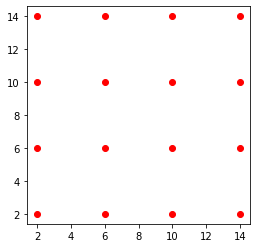

In [4]:
PosVlc = np.empty([NumVlc, 3])
for y in range(4):
    for x in range(4):
        PosVlc[y * 4 + x][0] = (2 * x + 1) * LenVlc
        PosVlc[y * 4 + x][1] = (2 * y + 1) * LenVlc
        PosVlc[y * 4 + x][2] = HeightRoom

fig,ax = plt.subplots(1, 1, figsize = (4, 4))
ax.plot(PosVlc[:,0], PosVlc[:,1], 'ro')

Channel Capacity of VLC Array

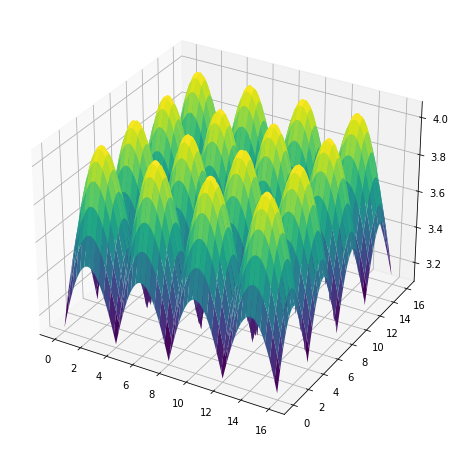

[[3.11333362e+08 3.12944138e+08 3.14536072e+08 ... 3.16108060e+08
  3.14536072e+08 3.12944138e+08]
 [3.12944138e+08 3.14577715e+08 3.16192503e+08 ... 3.17787374e+08
  3.16192503e+08 3.14577715e+08]
 [3.14536072e+08 3.16192503e+08 3.17830207e+08 ... 3.19448032e+08
  3.17830207e+08 3.16192503e+08]
 ...
 [3.16108060e+08 3.17787374e+08 3.19448032e+08 ... 3.21088860e+08
  3.19448032e+08 3.17787374e+08]
 [3.14536072e+08 3.16192503e+08 3.17830207e+08 ... 3.19448032e+08
  3.17830207e+08 3.16192503e+08]
 [3.12944138e+08 3.14577715e+08 3.16192503e+08 ... 3.17787374e+08
  3.16192503e+08 3.14577715e+08]]


In [5]:
X, Y = np.meshgrid(
    np.arange(0, LenRoom, 0.05), 
    np.arange(0, LenRoom, 0.05)
)
ZVlc = 0 * X

for i in range(np.size(ZVlc, 0)):
    for j in range(np.size(ZVlc, 1)):
        gain = 0

        for k in range(NumVlc):
            gain = max(gain, ChannelGainVlc(
                PosVlc[k] - np.asarray([X[i,j], Y[i,j], 0]),
                Ap, PhiHalf, Psi, gf, n
            ))

        SNR = (PVlc * gain * K)**2 / (BVlc * NVlc)
        ZVlc[i,j] = BVlc * np.log2(1 + SNR)

fig = plt.figure(figsize = (8, 8))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, ZVlc,cmap='viridis', edgecolor='none')
plt.show()

print(ZVlc)

## WiFI Channel Gain & Capacity

Channel Capacity
* Path Loss 
    $$ L_{path} = 20 log_{10}(\frac{f_c d^{2.75}}{d_{ref}^{1.75}}) - 147.5$$
* SNR
    $$ SNR = \frac{P_{wifi} G_{channel}}{B_{wifi} N_{wifi}}$$

In [6]:
def ChannelCapacityWifi(disVec, B_wifi, PWifi, NWifi, ZSigma):
    dis = np.linalg.norm(disVec)
    
    # Path Loss
    pathLoss = 0
    if(dis < dis_ref):
        pathLoss = 20 * np.log10(fc * dis) - 147.5
    else:
        pathLoss = 20 * np.log10(fc * dis**2.75 / dis_ref**1.75) - 147.5
        
    # Channel Gain
    H_wifi = 1
    channelGain = abs(H_wifi)**2 * 10 ** ((-pathLoss + ZSigma) / 10)
    SNR = 10 ** ((PWifi - NWifi) / 10) * channelGain / BWifi
    C = BWifi * np.log2(1 + SNR)
    return C

Parameters:
* $f_c = 2.4×10^9$
* $d_{ref} = 10$
* $Z_{\sigma} = 10$
* $P_{wifi} = 10$
* $B_{wifi} = 20×10^6$
* $N_{wifi} = -174$

In [7]:
fc = 2.4E9
dis_ref = 10
ZSigma = 10

PWifi = 10
BWifi = 20E6
NWifi = -174

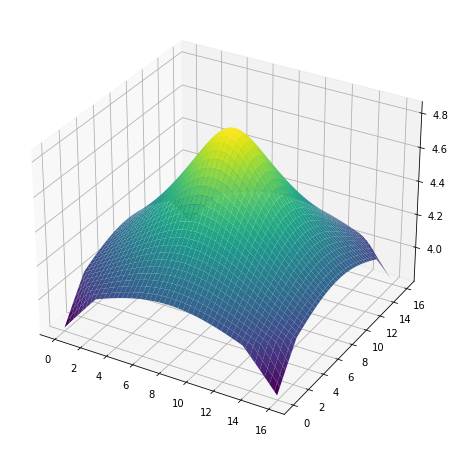

[[3.81143679e+08 3.81616445e+08 3.82089054e+08 ... 3.82561486e+08
  3.82089054e+08 3.81616445e+08]
 [3.81616445e+08 3.82092045e+08 3.82567503e+08 ... 3.83042801e+08
  3.82567503e+08 3.82092045e+08]
 [3.82089054e+08 3.82567503e+08 3.83045828e+08 ... 3.83524008e+08
  3.83045828e+08 3.82567503e+08]
 ...
 [3.82561486e+08 3.83042801e+08 3.83524008e+08 ... 3.84005088e+08
  3.83524008e+08 3.83042801e+08]
 [3.82089054e+08 3.82567503e+08 3.83045828e+08 ... 3.83524008e+08
  3.83045828e+08 3.82567503e+08]
 [3.81616445e+08 3.82092045e+08 3.82567503e+08 ... 3.83042801e+08
  3.82567503e+08 3.82092045e+08]]


In [8]:
ZWifi = 0 * X
PosWifi = np.asarray([LenRoom/2, LenRoom/2, HeightRoom])

for i in range(np.size(ZWifi, 0)):
    for j in range(np.size(ZWifi, 1)):
        ZWifi[i,j] = ChannelCapacityWifi(
            PosWifi - np.asarray([X[i,j], Y[i,j], 0]),
            BWifi, PWifi, NWifi, ZSigma
        )

fig = plt.figure(figsize = (8, 8))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, ZWifi,cmap='viridis', edgecolor='none')
plt.show()

print(ZWifi)

max VLC & WIFI Channel Capacity

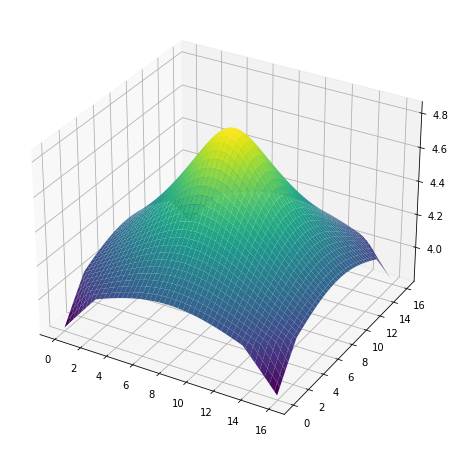

[[3.81143679e+08 3.81616445e+08 3.82089054e+08 ... 3.82561486e+08
  3.82089054e+08 3.81616445e+08]
 [3.81616445e+08 3.82092045e+08 3.82567503e+08 ... 3.83042801e+08
  3.82567503e+08 3.82092045e+08]
 [3.82089054e+08 3.82567503e+08 3.83045828e+08 ... 3.83524008e+08
  3.83045828e+08 3.82567503e+08]
 ...
 [3.82561486e+08 3.83042801e+08 3.83524008e+08 ... 3.84005088e+08
  3.83524008e+08 3.83042801e+08]
 [3.82089054e+08 3.82567503e+08 3.83045828e+08 ... 3.83524008e+08
  3.83045828e+08 3.82567503e+08]
 [3.81616445e+08 3.82092045e+08 3.82567503e+08 ... 3.83042801e+08
  3.82567503e+08 3.82092045e+08]]


In [9]:
ZAll = 0 * X

for i in range(np.size(ZAll, 0)):
    for j in range(np.size(ZAll, 1)):
        ZAll[i,j] = max(ZVlc[i,j], ZWifi[i,j])

fig = plt.figure(figsize = (8, 8))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, ZAll,cmap='viridis', edgecolor='none')
plt.show()

print(ZAll)

## Random Walk

In [10]:
def RandomWalk(timeMax, numUse, RoomSize):
    usePath = np.zeros((timeMax, numUse, 3))
    tmp = np.zeros((timeMax, numUse, 3))
    direct = np.zeros((numUse))

    # init
    for i in range(0, numUse):    
        usePath[0, i] = [
            RoomSize[0] * random.random(), 
            RoomSize[1] * random.random(), 
            RoomSize[2]
        ]
        direct[i] = 2 * np.pi * random.random()
    
    # walk
    for t in range(1, timeMax):
        for i in range(0, numUse):
            direct[i] += 2 * (np.pi * random.random() - np.pi/2)
            useValloc = 2.0 * random.random() + 0.2

            tmp[0, i] = use[t-1, i] + [
                useValloc * Tc * np.sin(direct[i]), 
                useValloc * Tc * np.cos(direct[i]), 0
                ]
        usePath = np.append(usePath, tmp, axis = 0)
        
    return usePath

In [11]:
timeMax = 100
numUse = 100

In [12]:
usePath = RandomWalk(timeMax, numUse, np.asarray([LenRoom, LenRoom, HeightRoom]))



NameError: name 'random' is not defined